<a href="https://colab.research.google.com/github/Bilkouristas/oxf-vis-25/blob/master/VIS_LAB2_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Feature Detection and Matching

The ability to accurately find correspondences between images is crucial for a wide range of applications, including image stitching, object recognition, 3D reconstruction, and navigation systems. This lab is designed to introduce you to the fundamental techniques used in computer vision for detecting and matching features between images. By exploring different methods of feature extraction and matching, you will gain hands-on experience with both traditional and deep learning-based approaches. Specifically the lab will cover:

**1. Matching with Handcrafted SIFT Features and OpenCV**: We will begin with one of the most influential feature extraction algorithms in computer vision: the Scale-Invariant Feature Transform (SIFT). Using OpenCV, we'll learn how to detect and match SIFT features between images. This will serve as a baseline for understanding feature matching and the effectiveness of handcrafted features.

**2. Transition to Learned Feature Detector/Descriptor SuperPoint**: After exploring traditional methods, we will shift our focus to a learned feature detector and descriptor called [SuperPoint](https://arxiv.org/pdf/1712.07629.pdf) and a matcher [LightGlue](https://github.com/cvg/LightGlue). Learned features represents a significant advancement, utilizing deep learning to automatically learn optimal features from data. We'll compare its performance to SIFT, highlighting the advantages of learned features in terms of robustness and accuracy.

**3. Developing an Image Similarity Function**: With the knowledge of learned feature detectors, you will then create a function that leverages these local features to determine whether two images are likely to depict the same scene. This involves understanding and implementing the feature matching function and coming up with a similarity metric based on the quality and quantity of matches.

**4. Image Retrieval Using Learned Features**: Finally, we will apply our image similarity function to the task of image retrieval. Given an exemplar image, you will use your function to search through a set of images and retrieve the most similar one. This exercise will demonstrate the practical application of feature matching, *image retrieval*, which involves identifying similar images within a large database, a common challenge in many computer vision systems.

By the end of this lab, you will have a comprehensive understanding of both traditional and modern approaches to feature extraction and matching, equipped with the skills to implement these techniques in real-world applications.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import time
import cv2
import numpy as np
import os

torch.set_grad_enabled(False)
images = Path("assets")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'


/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


## Dataset
The dataset we will use for this lab is the Oxford Buildings dataset ([link](https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/)) which contains 5k images of Oxford colleges collected from Flickr. The data is available [here](https://www.kaggle.com/datasets/skylord/oxbuildings/data), but you will be provided a link to the processed dataset to mount in the notebook.

In [ ]:
import gdown
%cd ..
file_id = "1XYTyJURsQYledZSjdo2YsMInztDkMRK2"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "oxford_buildings.zip")
!unzip "/content/oxford_buildings.zip"
%cd LightGlue

/content


Downloading...
From (original): https://drive.google.com/uc?id=1XYTyJURsQYledZSjdo2YsMInztDkMRK2
From (redirected): https://drive.google.com/uc?id=1XYTyJURsQYledZSjdo2YsMInztDkMRK2&confirm=t&uuid=175ec1b8-de32-4761-bd36-3bf6a127ce3a
To: /content/oxford_buildings.zip
100%|██████████| 80.8M/80.8M [00:00<00:00, 198MB/s]


Archive:  /content/oxford_buildings.zip
   creating: identified/
  inflating: identified/all_souls_000001.jpg  
  inflating: identified/all_souls_000005.jpg  
  inflating: identified/all_souls_000008.jpg  
  inflating: identified/all_souls_000013.jpg  
  inflating: identified/all_souls_000015.jpg  
  inflating: identified/all_souls_000016.jpg  
  inflating: identified/all_souls_000019.jpg  
  inflating: identified/all_souls_000021.jpg  
  inflating: identified/all_souls_000027.jpg  
  inflating: identified/all_souls_000035.jpg  
  inflating: identified/all_souls_000039.jpg  
  inflating: identified/all_souls_000040.jpg  
  inflating: identified/all_souls_000044.jpg  
  inflating: identified/all_souls_000045.jpg  
  inflating: identified/all_souls_000047.jpg  
  inflating: identified/all_souls_000060.jpg  
  inflating: identified/all_souls_000061.jpg  
  inflating: identified/all_souls_000062.jpg  
  inflating: identified/all_souls_000073.jpg  
  inflating: identified/all_souls_000084.j

# 1. Feature matching using SIFT


Scale-Invariant Feature Transform (SIFT) is a classical (handcrafted) feature detection algorithm in computer vision to detect and describe local features in images. The algorithm was designed for applications where the scale and orientation of the images may vary. In OpenCV, SIFT matching involves several key steps.

A. Feature Detection and Descriptor Extraction
* Initialization: First, you create a SIFT object using cv2.SIFT_create(). This object will be used to detect SIFT keypoints and compute their descriptors.
* Keypoint Detection and Descriptor Computation: For each image, you use the detectAndCompute method on the SIFT object to find keypoints and compute their descriptors. This method takes an image and an optional mask as inputs and returns keypoints and descriptors.

B. Matching Descriptors Between Images
* Matcher Initialization: OpenCV provides several matcher classes, but for SIFT, a common choice is either the Brute-Force matcher (cv2.BFMatcher) or the FLANN-based matcher (cv2.FlannBasedMatcher). For SIFT, the Brute-Force matcher is often used with the Euclidean distance.

* Descriptor Matching: You use the matcher's match method to find the best matches between the two sets of descriptors. This method takes two sets of descriptors as input and returns the best matches.

* Optionally, you can sort the matches based on their distance to get the most reliable matches.

## Easy example

The images '/content/identified/all_souls_000091.jpg' and '/content/identified/all_souls_000055.jpg' represent different views of the same college under nearly the same lighting conditions. Complete the following functions to detect and match keypoints in the images.

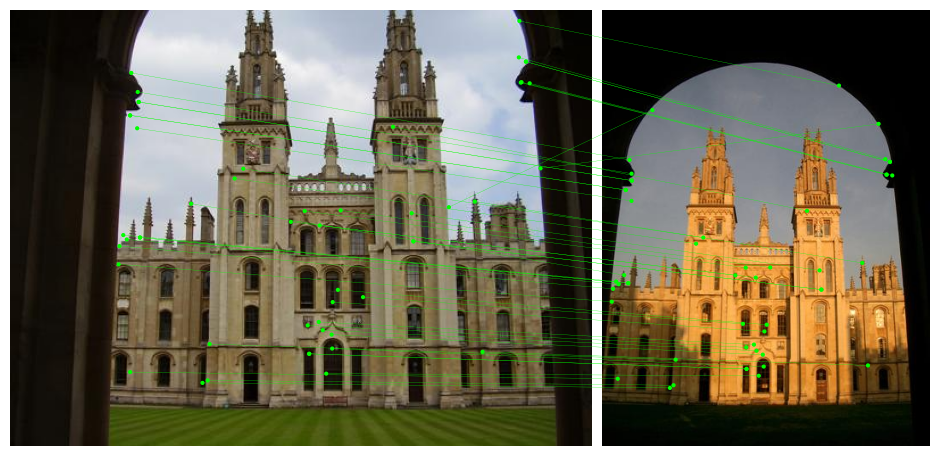

In [ ]:
def load_and_preprocess_image(image_path):
    """
    Load an image and convert it to RGB.

    Parameters:
    - image_path: Path to the image file.

    Returns:
    - img_rgb: The loaded image in RGB format.
    """
    img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    return img_rgb

def detect_and_describe_features(image):
    """
    Detect keypoints and compute descriptors using SIFT.

    Parameters:
    - image: The image in which features are to be detected.

    Returns:
    - keypoints: Detected keypoints in the image.
    - descriptors: Descriptors of the detected keypoints.
    """
    # Your code here to initialize SIFT detector, detect keypoints, and compute descriptors
    # Initialize SIFT detector using cv2
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    keypoints, descriptors = sift.detectAndCompute(image, None)

    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    """
    Match features between two sets of descriptors.

    Parameters:
    - descriptors1: Descriptors from the first image.
    - descriptors2: Descriptors from the second image.

    Returns:
    - matches: The matched features between the two sets of descriptors.
    """
    # Your code here to create a matcher and match descriptors

    # Create a BFMatcher object
    # You can also use cv2.FlannBasedMatcher if you want FLANN based matcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Match descriptors

    return matches

def convert_matches_to_numpy(matches, keypoints1, keypoints2):
    """
    Convert matched keypoints to NumPy arrays. This is mainly for visualisation using the LightGlue `Viz2D` function

    Parameters:
    - matches: Matched features between two images.
    - keypoints1: Keypoints from the first image.
    - keypoints2: Keypoints from the second image.

    Returns:
    - matched_pts1: Matched points from the first image as a NumPy arrays.
    - matched_pts2: Matched points from the second image as a NumPy arrays.
    """
    matched_pts1 = []
    matched_pts2 = []

    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx

        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        matched_pts1.append([x1, y1])
        matched_pts2.append([x2, y2])
    matched_pts1 = np.asarray(matched_pts1)
    matched_pts2 = np.asarray(matched_pts2)

    return matched_pts1, matched_pts2

# Load and preprocess images
img1_path = '/content/identified/all_souls_000091.jpg'
img2_path = '/content/identified/all_souls_000055.jpg'
img1 = load_and_preprocess_image(img1_path)
img2 = load_and_preprocess_image(img2_path)

# Detect keypoints and compute descriptors with SIFT for both images
keypoints1, descriptors1 = detect_and_describe_features(img1)
keypoints2, descriptors2 = detect_and_describe_features(img2)

# Match descriptors between the two sets of descriptors
matches = match_features(descriptors1, descriptors2)

# Sort them in the order of their distance (the lower the better)
# You can slice to an arbitrary number of the matches, e.g. 400
matches = sorted(matches, key=lambda x: x.distance)[:50]

# Convert matches to NumPy arrays for visualization
m_kpts0, m_kpts1 = convert_matches_to_numpy(matches, keypoints1, keypoints2)

# Visualization of matches
axes = viz2d.plot_images([img1, img2])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

### 🔍 Visualizing SIFT Keypoints
Let’s visualize the SIFT keypoints detected in one of the images.
Each keypoint represents a distinctive region that SIFT found to be stable across changes in scale and rotation.

We use cv2.drawKeypoints to draw circles and orientation arrows over each detected keypoint.

- The size of the circle indicates the scale of the keypoint (how large the local structure is).

- The small line inside the circle shows the dominant orientation (direction of strongest gradient).

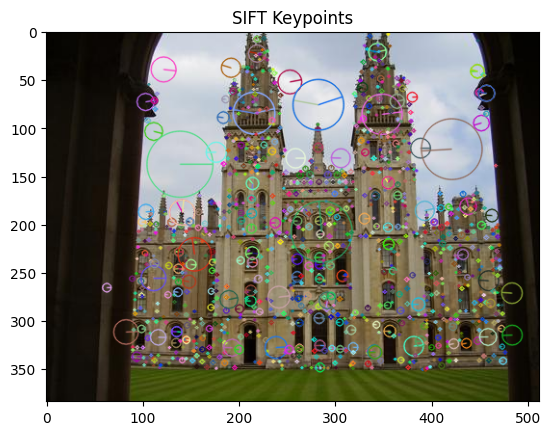

In [ ]:
img_kp = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_kp)
plt.title('SIFT Keypoints')
plt.show()

## More difficult example

The images '/content/identified/all_souls_000134.jpg' and '/content/identified/all_souls_000026.jpg' represent different views of the same college but from a very different viewpoint. Use the functions implemented above to find local matches for these two images.

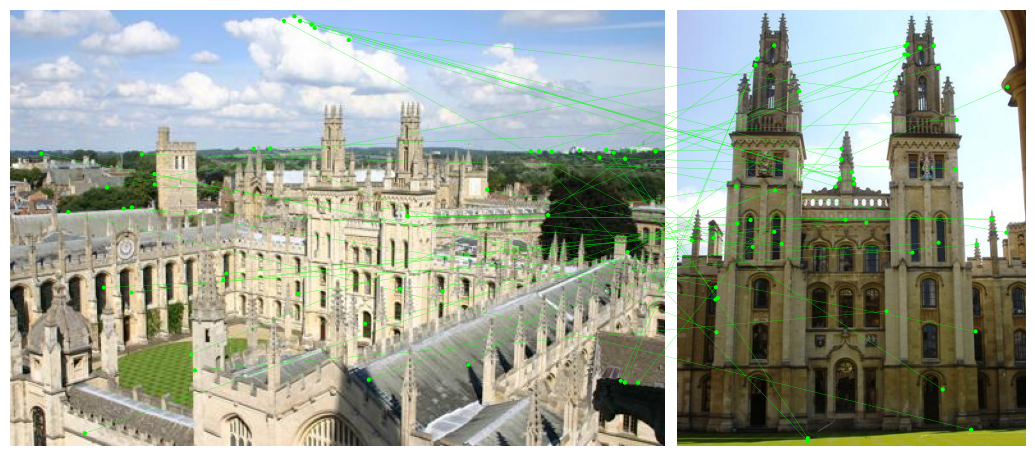

In [ ]:
# You can use the code from before for this section

# Load and preprocess images
img1_path = '/content/identified/all_souls_000134.jpg'
img2_path = '/content/identified/all_souls_000026.jpg'
img1 = load_and_preprocess_image(img1_path)
img2 = load_and_preprocess_image(img2_path)

# Detect keypoints and compute descriptors with SIFT for both images
keypoints1, descriptors1 = detect_and_describe_features(img1)
keypoints2, descriptors2 = detect_and_describe_features(img2)

# Match descriptors between the two sets of descriptors
matches = match_features(descriptors1, descriptors2)

# Sort them in the order of their distance (the lower the better)
# You can slice to an arbitrary number of the matches, e.g. 20
matches = sorted(matches, key=lambda x: x.distance)[:50]

# Convert matches to NumPy arrays for visualization
m_kpts0, m_kpts1 = convert_matches_to_numpy(matches, keypoints1, keypoints2)

# Visualization: Plot the images and the matches
axes = viz2d.plot_images([img1, img2])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

# 2. Learned Feature extraction and matching



SuperPoint is a deep learning-based feature detection algorithm that learns to detect interest points and their descriptors from images. Unlike traditional algorithms that rely on handcrafted features, SuperPoint leverages a neural network to identify keypoints and compute their descriptors simultaneously. This results in keypoints that are highly discriminative and more robust to changes in scale, rotation, and illumination than traditional methods like SIFT.

Building on the capabilities of SuperPoint, LightGlue is designed to match the detected keypoints between pairs of images with icreased accuracy. LightGlue employs a graph neural network that considers the global context of keypoints across both images, enabling it to resolve ambiguities and match features even in challenging conditions.

Implementing SuperPoint and LightGlue involves leveraging pre-trained models, as training from scratch requires substantial computational resources and a large dataset. Fortunately, open-source implementations and pre-trained models are available, allowing for straightforward integration into computer vision projects.



In [ ]:
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 127MB/s]


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth


100%|██████████| 45.3M/45.3M [00:00<00:00, 317MB/s]


## Easy example

Here we will revisit the 'easy' pair above ('/identified/all_souls_000091.jpg' and '/identified/all_souls_000055.jpg') but using SuperPoint and LightGlue to see whether learned features can find more reliable matches. Read up on how to do this by looking at the LightGlue [repository](https://github.com/cvg/LightGlue).

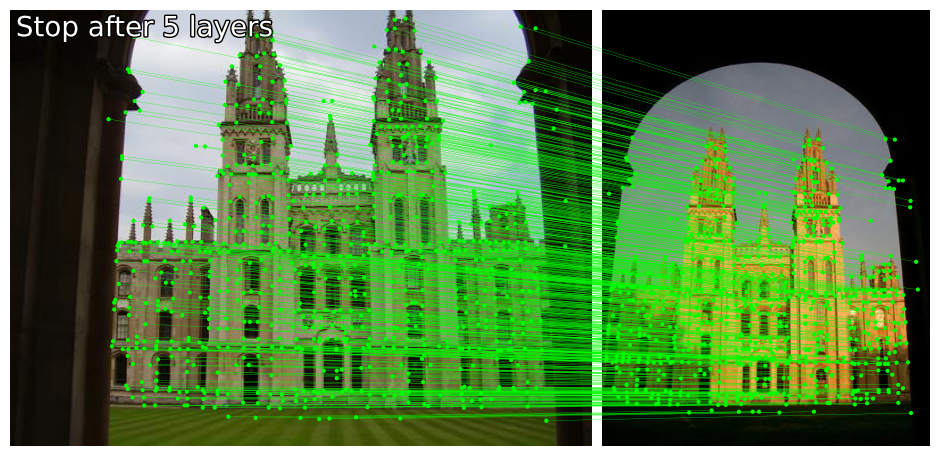

In [ ]:
# Load the images using a predefined load_image function
image0 = load_image("/content/identified/all_souls_000091.jpg")
image1 = load_image("/content/identified/all_souls_000055.jpg")

# Send the images to a device for processing, e.g., GPU if available
# Use image.to(device) to transfer images to the specified device
image0 = image0.to(device)
image1 = image1.to(device)

# Extract features from both images using a feature extractor
# Use extractor.extract(image) for feature extraction
feats0 = extractor.extract(image0)
feats1 = extractor.extract(image1)

# Match the features extracted from both images using a matcher
# Use matcher({"image0": feats0, "image1": feats1}) to find matches between features
matches01 = matcher({"image0": feats0, "image1": feats1})

# Remove the batch dimension from the extracted features and matches
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]

# Extract keypoints from the feature sets of both images
# Access keypoints using feats0["keypoints"] and feats1["keypoints"]
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]

# Filter the keypoints based on the matches obtained
# Use indexing with matches to filter keypoints: kpts0[matches[..., 0]], kpts1[matches[..., 1]]
points0, points1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# Visualize the images and their matching keypoints
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(points0, points1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

## More difficult example

Now we try a difficult pair ('/identified/all_souls_000134.jpg' and '/identified/all_souls_000026.jpg') to see whether the learned features still work well with significant light and viewpoint changes.

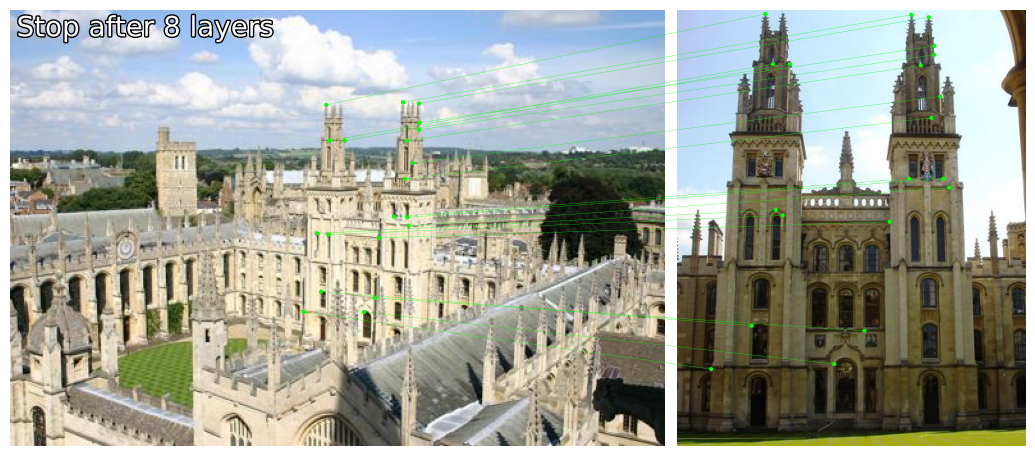

In [ ]:
# Again, you can reuse the code that you have above

# Load images using the predefined load_image function
image0 = load_image("/content/identified/all_souls_000134.jpg")
image1 = load_image("/content/identified/all_souls_000026.jpg")

# Transfer images to a specified device for computation (e.g., GPU)
# Apply .to(device) method to images after loading
image0, image1 = image0.to(device), image1.to(device)

# Extract features from both images using the feature extractor
# Use extractor.extract(image.to(device)) for each image
feats0 = extractor.extract(image0)
feats1 = extractor.extract(image1)

# Match features between the two images using the matcher function
# Apply matcher({"image0": feats0, "image1": feats1}) to get matches
matches01 = matcher({"image0": feats0, "image1": feats1})

# Remove the batch dimension from the extracted features and matches
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]

# Extract keypoints from the feature dictionaries of both images
# Access keypoints via feats0["keypoints"] and feats1["keypoints"]
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]

# Select matched keypoints based on the matches array
# Filter keypoints: kpts0[matches[..., 0]] and kpts1[matches[..., 1]]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]][:20], kpts1[matches[..., 1]][:20]

# Visualize the images and their keypoints matches
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

Another interesting pair to try:

[ashmolean_000028.jpg,
ashmolean_000078.jpg]

## A non-matching image pair

To deepen your understanding of how the matching algorithm can be used for image retrieval, we will first look at how the algorithm performs with non-matching image pairs. In this section you will therefore conduct an experiment by running the algorithm on a pair of images that do not match. You should collect the scores generated by the matcher (eg. *matches01['scores']*) for the non-matching images. After this you need to plot the distribution of the scores for the matches. This visualization will offer crucial insights into the algorithm's behavior in differentiating between matching and non-matching images.

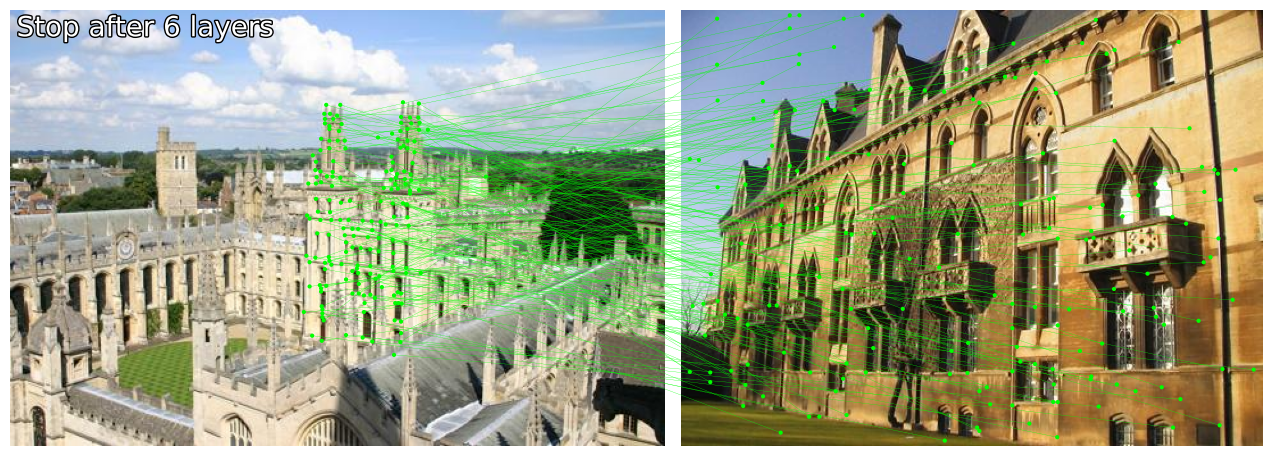

In [ ]:
# Again, you can reuse the code that you have above

# Load non-matching image pair
image0 = load_image("/content/identified/all_souls_000134.jpg")
image1 = load_image("/content/identified/christ_church_000081.jpg")

# Transfer images to a specified device for computation (e.g., GPU)
# Apply .to(device) method to images after loading
image0, image1 = image0.to(device), image1.to(device)

# Extract features from both images using the feature extractor
# Use extractor.extract(image.to(device)) for each image
feats0 = extractor.extract(image0)
feats1 = extractor.extract(image1)

# Match features between the two images using the matcher function
# Apply matcher({"image0": feats0, "image1": feats1}) to get matches
matches_01_nomatch = matcher({"image0": feats0, "image1": feats1})

# Remove the batch dimension from the extracted features and matches
feats0, feats1, matches01_nomatch = [
    rbd(x) for x in [feats0, feats1, matches_01_nomatch]
]

# Extract keypoints from the feature dictionaries of both images
# Access keypoints via feats0["keypoints"] and feats1["keypoints"]
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]

# Select matched keypoints based on the matches array
# Filter keypoints: kpts0[matches[..., 0]] and kpts1[matches[..., 1]]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# Visualize the images and their keypoints matches
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01_nomatch["stop"]} layers', fs=20)

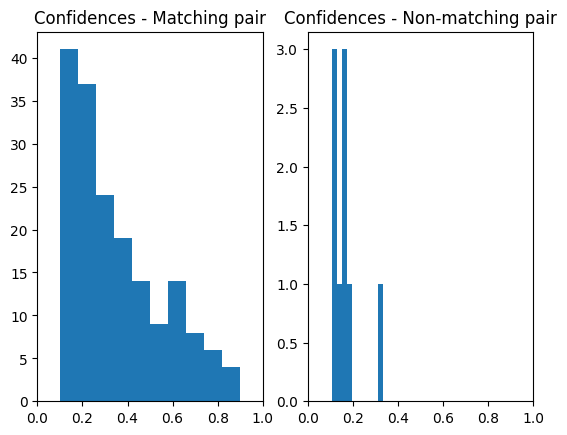

In [ ]:
# Plot the distribution of the matches
plt.subplot(1,2,1)
plt.title('Confidences - Matching pair')
plt.hist(matches01['scores'].cpu().numpy())
plt.xlim(0, 1)
plt.subplot(1,2,2)
plt.title('Confidences - Non-matching pair')
plt.hist(matches01_nomatch['scores'].cpu().numpy())
plt.xlim(0, 1)
plt.show()

# 3. Image Similarity using Local Features




Based on your observations above, implement a function that takes two images, performs local feature matching and returns a score representing how likely it is that the two images are a match.

In [ ]:
def calculate_scene_similarity_with_matching(image0, image1, extractor, matcher, score_threshold=0.5):
    """
    Extracts features from two images, matches them, and calculates a score indicating whether the images are of the same scene.

    Parameters:
    - image0, image1: The two images to compare.
    - extractor: A feature extractor function or object.
    - matcher: A matcher function or object for matching features between two sets.
    - score_threshold: Threshold for filtering matches based on their score.

    Returns:
    - A score indicating the likelihood of the images being of the same scene.
    """
    # Extract features from both images
    feats0 = extractor.extract(image0)
    feats1 = extractor.extract(image1)

    # Match features between the two images
    matches01 = matcher({"image0": feats0, "image1": feats1})

    # Remove the batch dimension
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]

    # Assuming matches01 contains indices of matches and their scores
    matches = matches01['matches']
    scores = matches01['scores']

    # Filter matches based on the score threshold
    high_quality_matches = matches[scores > score_threshold]

    # Calculate the average score of the high-quality matches
    if len(high_quality_matches) > 0:
        average_score = scores[scores > score_threshold].mean()
    else:
        average_score = torch.tensor(0.).to(device)

    # Create your own metric for calculating the final score
    # using *both* the number of high-quality matches and their average score
    final_score = (len(high_quality_matches) * average_score) / len(matches)

    return final_score.cpu().numpy()

Run your scoring function on some matching and non-matching pairs and check the output

In [ ]:
# Non matching pair
image0 = load_image("/content/identified/all_souls_000134.jpg").to(device)
image1 = load_image("/content/identified/christ_church_000081.jpg").to(device)

score = calculate_scene_similarity_with_matching(image0, image1, extractor, matcher, score_threshold=0.5)
print(f"Score of non-matching pair: {score}")

# Matching pair
image0 = load_image("/content/identified/all_souls_000134.jpg").to(device)
image1 = load_image("/content/identified/all_souls_000073.jpg").to(device)

score = calculate_scene_similarity_with_matching(image0, image1, extractor, matcher, score_threshold=0.5)
print(f"Score of matching pair: {score}")

Score of non-matching pair: 0.0
Score of matching pair: 0.6468735337257385


# 4. Image Retrieval


In this section of the lab, you will make use of the similarity function developed earlier to tackle an image retrieval challenge. Your task is to find the closest matching image for each "unidentified" image by comparing it against a set of "identified" images stored in a folder. For every unidentified image, you will search through the identified images, utilize the similarity function to determine the most similar match, and then extract the name of the building from the filename of the closest matching image. Filenames follow the format {building_name}_{frame_number}.jpg, where you are required to return just the building_name. This exercise will test your ability to apply image feature extraction and matching techniques for practical image retrieval tasks.

In [ ]:
def find_closest_match_for_image(query_image_name, unidentified_folder, identified_folder, extractor, matcher):
    """
    Finds the closest matching image in 'identified_folder' for the specified 'query_image_name'.

    Parameters:
    - query_image_name: Filename of the specific unidentified image to compare.
    - unidentified_folder: Path to the folder containing the unidentified image.
    - identified_folder: Path to the folder containing identified images.
    - extractor: Feature extractor object or function.
    - matcher: Matcher object or function for comparing image features.

    Returns:
    - The building name of the closest matching identified image.
    """
    unid_image_path = os.path.join(unidentified_folder, query_image_name)

    highest_score = -1
    closest_building = None

    # Compare with each identified image
    for id_file in os.listdir(identified_folder):
        image0 = load_image(unid_image_path).to(device)
        image1 = load_image(os.path.join(identified_folder,id_file)).to(device)

        # Calculate similarity score using the defined scene_similarity function
        score = calculate_scene_similarity_with_matching(image0, image1, extractor, matcher)

        # Update closest match if current score is higher
        if score > highest_score:
            highest_score = score
            closest_building = id_file[:-11]  # Extract building name
            print(f"New highest score {highest_score:.2f} with image {id_file}")

    return closest_building


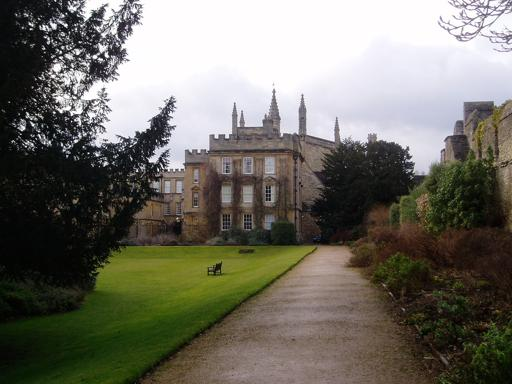

In [ ]:
from PIL import Image
unidentified_image = Image.open('/content/unidentified/oxford_002627.jpg')
display(unidentified_image)

In [ ]:
#find_closest_match_for_image('/content/unidentified/oxford_000503.jpg', '/content/unidentified', '/content/identified', extractor, matcher)
find_closest_match_for_image('/content/unidentified/oxford_002627.jpg', '/content/unidentified', '/content/identified', extractor, matcher)

New highest score 0.05 with image new_000922.jpg
New highest score 0.07 with image new_000339.jpg
New highest score 0.12 with image magdalen_000000.jpg
New highest score 0.62 with image new_000556.jpg


'new'

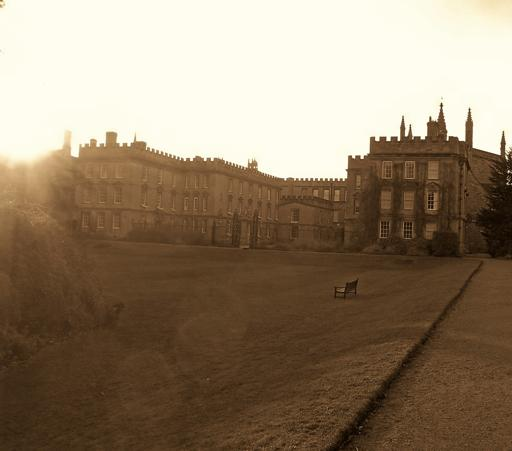

In [ ]:
img = Image.open('/content/identified/new_000556.jpg')
display(img)